<a href="https://colab.research.google.com/github/namanphy/EVA5/blob/main/S10/main_S10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting up code

#### Cloning the required [repository](https://github.com/namanphy/EVA5/) and adding the path to the code directory.

In [ ]:
import sys

! git clone https://github.com/namanphy/EVA5.git
! pip install git+https://github.com/albumentations-team/albumentations.git
! pip install torch-lr-finder

sys.path.append('EVA5/S10/')

#### Importing the required modules and files

In [20]:
import cuda
from data.dataset import CIFAR10
from data.dataloader import data_loader
from model.model import ResNet18, model_summary
from model.optimizer import sgd_optimizer
from model.loss import cross_entropy_loss
from model.trainer import Trainer
from utils import set_seed, plot_metric, identify_misclassification, plot_results
from gradcam.gradcam import plot_gradcam

In [21]:
set_seed(123)
use_cuda = cuda.cuda_is_available()
device = cuda.enable_cuda()

## Making the data ready

In [22]:
cifar10 = CIFAR10(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), rotation=6, horizontal_flip=0.5, cutout=0.5, cutout_hw_ratio=2)

train_set = cifar10.download('../data', train=True, apply_transform=True)
test_set = cifar10.download('../data', train=False, apply_transform=True)

# Loading the datasets into Pytorch Dataloaders
train_loader = data_loader(train_set, 64, use_cuda, num_workers=4)
test_loader = data_loader(test_set, 64, use_cuda, num_workers=4)

Files already downloaded and verified
Transforms :  {'train': True, 'mean': (0.5, 0.5, 0.5), 'std': (0.5, 0.5, 0.5), 'rotation': 6, 'horizontal_flip': 0.5, 'cutout': 0.5, 'cutout_height': 16, 'cutout_width': 16}
Files already downloaded and verified
Transforms :  {'train': False, 'mean': (0.5, 0.5, 0.5), 'std': (0.5, 0.5, 0.5), 'rotation': 6, 'horizontal_flip': 0.5, 'cutout': 0.5, 'cutout_height': 16, 'cutout_width': 16}
Files already downloaded and verified


#### Printing the shape of one image

In [23]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print('shape of one image - ', images[0].shape)

shape of one image -  torch.Size([3, 32, 32])


## Import model architecture

In [24]:
model = ResNet18()
model.name = 'ResNet18' # Giving my model a name
model_summary(model.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

## Setting up Training

In [25]:
results = {}  # empty dict to store results

criterion = cross_entropy_loss()
optimizer = sgd_optimizer(model, lr=0.01, l2_factor=0)

#### Finding LR - using cyclic LR policy

In [26]:
from torch_lr_finder import LRFinder

lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, start_lr=0.00001, end_lr=1, num_iter=300)


Learning rate search finished. See the graph with {finder_name}.plot()


Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


LR suggestion: steepest gradient
Suggested LR: 1.98E-01


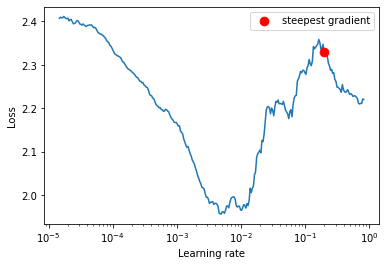

In [27]:
lr_finder.plot()
lr_finder.reset()

Seeing from the above graph - **0.001** to **0.006** is where loss is decreasing steeply.

Choosing the LR as - **0.005**

#### Training Model

In [28]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Optimization
#   min_lr = 0.001
#   factor = 0.9

In [29]:
# Re intitialising optimizer with new LR
optimizer = sgd_optimizer(model, lr=0.005, l2_factor=0)

# Setting up the trainer
trainer = Trainer(model, optimizer, criterion, train_loader, valid_data_loader=test_loader, lr_scheduler=scheduler, 
                  scheduler_monitor_value='loss', l1_loss=False)

results['resnet18'] = trainer.train(50)
trainer.save('cifar10_model')

  0%|          | 0/782 [00:00<?, ?it/s]

------------ EPOCH 1 -------------


Loss=1.5240163803100586 Batch_id=781 Accuracy=45.42: 100%|██████████| 782/782 [01:41<00:00,  7.67it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0965, Accuracy: 6124/10000 (61%)

------------ EPOCH 2 -------------


Loss=0.6716705560684204 Batch_id=781 Accuracy=62.83: 100%|██████████| 782/782 [01:42<00:00,  7.64it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7656, Accuracy: 7298/10000 (73%)

------------ EPOCH 3 -------------


Loss=1.662784218788147 Batch_id=781 Accuracy=69.73: 100%|██████████| 782/782 [01:42<00:00,  7.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7005, Accuracy: 7595/10000 (76%)

------------ EPOCH 4 -------------


Loss=1.0084800720214844 Batch_id=781 Accuracy=73.45: 100%|██████████| 782/782 [01:42<00:00,  7.64it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5912, Accuracy: 7999/10000 (80%)

------------ EPOCH 5 -------------


Loss=0.7865533232688904 Batch_id=781 Accuracy=76.51: 100%|██████████| 782/782 [01:42<00:00,  7.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6149, Accuracy: 7940/10000 (79%)

------------ EPOCH 6 -------------


Loss=0.6649629473686218 Batch_id=781 Accuracy=78.07: 100%|██████████| 782/782 [01:42<00:00,  7.64it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5559, Accuracy: 8113/10000 (81%)

------------ EPOCH 7 -------------


Loss=0.8063857555389404 Batch_id=781 Accuracy=80.17: 100%|██████████| 782/782 [01:42<00:00,  7.66it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5558, Accuracy: 8202/10000 (82%)

------------ EPOCH 8 -------------


Loss=0.37930190563201904 Batch_id=781 Accuracy=81.33: 100%|██████████| 782/782 [01:42<00:00,  7.65it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6300, Accuracy: 8051/10000 (81%)

------------ EPOCH 9 -------------


Loss=0.5884391665458679 Batch_id=781 Accuracy=82.84: 100%|██████████| 782/782 [01:43<00:00,  7.56it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5101, Accuracy: 8350/10000 (84%)

------------ EPOCH 10 -------------


Loss=0.3011445701122284 Batch_id=781 Accuracy=83.48: 100%|██████████| 782/782 [01:43<00:00,  7.57it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4533, Accuracy: 8530/10000 (85%)

------------ EPOCH 11 -------------


Loss=0.8523868322372437 Batch_id=781 Accuracy=84.59: 100%|██████████| 782/782 [01:43<00:00,  7.56it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4591, Accuracy: 8500/10000 (85%)

------------ EPOCH 12 -------------


Loss=0.7295987010002136 Batch_id=781 Accuracy=85.04: 100%|██████████| 782/782 [01:43<00:00,  7.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4451, Accuracy: 8590/10000 (86%)

------------ EPOCH 13 -------------


Loss=0.3252197802066803 Batch_id=781 Accuracy=86.12: 100%|██████████| 782/782 [01:43<00:00,  7.54it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4116, Accuracy: 8714/10000 (87%)

------------ EPOCH 14 -------------


Loss=0.22837260365486145 Batch_id=781 Accuracy=86.71: 100%|██████████| 782/782 [01:43<00:00,  7.55it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4730, Accuracy: 8556/10000 (86%)

------------ EPOCH 15 -------------


Loss=0.2333044558763504 Batch_id=781 Accuracy=87.73: 100%|██████████| 782/782 [01:43<00:00,  7.57it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4453, Accuracy: 8620/10000 (86%)

------------ EPOCH 16 -------------


Loss=0.3708905577659607 Batch_id=781 Accuracy=88.07: 100%|██████████| 782/782 [01:43<00:00,  7.59it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4270, Accuracy: 8674/10000 (87%)

Epoch    16: reducing learning rate of group 0 to 5.0000e-03.
------------ EPOCH 17 -------------


Loss=0.7390281558036804 Batch_id=781 Accuracy=88.59: 100%|██████████| 782/782 [01:43<00:00,  7.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4631, Accuracy: 8600/10000 (86%)

------------ EPOCH 18 -------------


Loss=0.23897209763526917 Batch_id=781 Accuracy=89.03: 100%|██████████| 782/782 [01:43<00:00,  7.54it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4993, Accuracy: 8541/10000 (85%)

------------ EPOCH 19 -------------


Loss=0.5434780120849609 Batch_id=781 Accuracy=89.49: 100%|██████████| 782/782 [01:43<00:00,  7.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4957, Accuracy: 8583/10000 (86%)

Epoch    19: reducing learning rate of group 0 to 2.5000e-03.
------------ EPOCH 20 -------------


Loss=0.361881822347641 Batch_id=781 Accuracy=90.12: 100%|██████████| 782/782 [01:43<00:00,  7.54it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3802, Accuracy: 8816/10000 (88%)

------------ EPOCH 21 -------------


Loss=0.2414894551038742 Batch_id=781 Accuracy=90.79: 100%|██████████| 782/782 [01:43<00:00,  7.56it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3910, Accuracy: 8801/10000 (88%)

------------ EPOCH 22 -------------


Loss=0.4943907856941223 Batch_id=781 Accuracy=90.88: 100%|██████████| 782/782 [01:43<00:00,  7.55it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3673, Accuracy: 8854/10000 (89%)

------------ EPOCH 23 -------------


Loss=0.7063451409339905 Batch_id=781 Accuracy=91.31: 100%|██████████| 782/782 [01:43<00:00,  7.57it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4549, Accuracy: 8791/10000 (88%)

------------ EPOCH 24 -------------


Loss=0.4796375334262848 Batch_id=781 Accuracy=91.70: 100%|██████████| 782/782 [01:43<00:00,  7.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3946, Accuracy: 8831/10000 (88%)

------------ EPOCH 25 -------------


Loss=0.0896955206990242 Batch_id=781 Accuracy=92.20: 100%|██████████| 782/782 [01:45<00:00,  7.43it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3982, Accuracy: 8855/10000 (89%)

Epoch    25: reducing learning rate of group 0 to 1.2500e-03.
------------ EPOCH 26 -------------


Loss=0.8120965957641602 Batch_id=781 Accuracy=92.36: 100%|██████████| 782/782 [01:45<00:00,  7.42it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4848, Accuracy: 8696/10000 (87%)

------------ EPOCH 27 -------------


Loss=0.2921566963195801 Batch_id=781 Accuracy=92.66: 100%|██████████| 782/782 [01:45<00:00,  7.42it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3899, Accuracy: 8864/10000 (89%)

------------ EPOCH 28 -------------


Loss=0.23871736228466034 Batch_id=781 Accuracy=92.73: 100%|██████████| 782/782 [01:45<00:00,  7.44it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4225, Accuracy: 8845/10000 (88%)

Epoch    28: reducing learning rate of group 0 to 6.2500e-04.
------------ EPOCH 29 -------------


Loss=0.32359641790390015 Batch_id=781 Accuracy=93.09: 100%|██████████| 782/782 [01:45<00:00,  7.43it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4018, Accuracy: 8907/10000 (89%)

------------ EPOCH 30 -------------


Loss=0.2452375441789627 Batch_id=781 Accuracy=93.25: 100%|██████████| 782/782 [01:45<00:00,  7.41it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3811, Accuracy: 8912/10000 (89%)

------------ EPOCH 31 -------------


Loss=0.19594773650169373 Batch_id=781 Accuracy=93.66: 100%|██████████| 782/782 [01:45<00:00,  7.44it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4043, Accuracy: 8902/10000 (89%)

Epoch    31: reducing learning rate of group 0 to 3.1250e-04.
------------ EPOCH 32 -------------


Loss=0.560273289680481 Batch_id=781 Accuracy=93.77: 100%|██████████| 782/782 [01:45<00:00,  7.43it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4078, Accuracy: 8910/10000 (89%)

------------ EPOCH 33 -------------


Loss=0.02974586933851242 Batch_id=781 Accuracy=94.13: 100%|██████████| 782/782 [01:45<00:00,  7.42it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3958, Accuracy: 8954/10000 (90%)

------------ EPOCH 34 -------------


Loss=0.903382420539856 Batch_id=781 Accuracy=94.28: 100%|██████████| 782/782 [01:45<00:00,  7.44it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3861, Accuracy: 8962/10000 (90%)

Epoch    34: reducing learning rate of group 0 to 1.5625e-04.
------------ EPOCH 35 -------------


Loss=0.41469669342041016 Batch_id=781 Accuracy=94.60: 100%|██████████| 782/782 [01:44<00:00,  7.46it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4020, Accuracy: 8945/10000 (89%)

------------ EPOCH 36 -------------


Loss=0.47307202219963074 Batch_id=781 Accuracy=94.70: 100%|██████████| 782/782 [01:44<00:00,  7.51it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4123, Accuracy: 8905/10000 (89%)

------------ EPOCH 37 -------------


Loss=0.07077275961637497 Batch_id=781 Accuracy=94.67: 100%|██████████| 782/782 [01:44<00:00,  7.50it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4704, Accuracy: 8839/10000 (88%)

Epoch    37: reducing learning rate of group 0 to 7.8125e-05.
------------ EPOCH 38 -------------


Loss=0.014585328288376331 Batch_id=781 Accuracy=94.91: 100%|██████████| 782/782 [01:44<00:00,  7.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3918, Accuracy: 8950/10000 (90%)

------------ EPOCH 39 -------------


Loss=0.16935081779956818 Batch_id=781 Accuracy=95.20: 100%|██████████| 782/782 [01:44<00:00,  7.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4242, Accuracy: 8916/10000 (89%)

------------ EPOCH 40 -------------


Loss=0.1896340250968933 Batch_id=781 Accuracy=95.33: 100%|██████████| 782/782 [01:44<00:00,  7.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4308, Accuracy: 8913/10000 (89%)

Epoch    40: reducing learning rate of group 0 to 3.9063e-05.
------------ EPOCH 41 -------------


Loss=0.2718718945980072 Batch_id=781 Accuracy=95.31: 100%|██████████| 782/782 [01:44<00:00,  7.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4194, Accuracy: 8981/10000 (90%)

------------ EPOCH 42 -------------


Loss=0.05196811258792877 Batch_id=781 Accuracy=95.51: 100%|██████████| 782/782 [01:44<00:00,  7.48it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4319, Accuracy: 8924/10000 (89%)

------------ EPOCH 43 -------------


Loss=0.042663175612688065 Batch_id=781 Accuracy=95.84: 100%|██████████| 782/782 [01:44<00:00,  7.48it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4096, Accuracy: 9014/10000 (90%)

Epoch    43: reducing learning rate of group 0 to 1.9531e-05.
------------ EPOCH 44 -------------


Loss=0.2007356882095337 Batch_id=781 Accuracy=95.74: 100%|██████████| 782/782 [01:44<00:00,  7.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4485, Accuracy: 8931/10000 (89%)

------------ EPOCH 45 -------------


Loss=0.10684461891651154 Batch_id=781 Accuracy=95.96: 100%|██████████| 782/782 [01:44<00:00,  7.46it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4432, Accuracy: 8953/10000 (90%)

------------ EPOCH 46 -------------


Loss=0.16196773946285248 Batch_id=781 Accuracy=96.12: 100%|██████████| 782/782 [01:44<00:00,  7.46it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4217, Accuracy: 8957/10000 (90%)

Epoch    46: reducing learning rate of group 0 to 9.7656e-06.
------------ EPOCH 47 -------------


Loss=0.05538787320256233 Batch_id=781 Accuracy=96.10: 100%|██████████| 782/782 [01:44<00:00,  7.45it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4310, Accuracy: 8939/10000 (89%)

------------ EPOCH 48 -------------


Loss=0.12383552640676498 Batch_id=781 Accuracy=96.34: 100%|██████████| 782/782 [01:44<00:00,  7.46it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3999, Accuracy: 9015/10000 (90%)

------------ EPOCH 49 -------------


Loss=0.016507744789123535 Batch_id=781 Accuracy=96.17: 100%|██████████| 782/782 [01:44<00:00,  7.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4103, Accuracy: 9037/10000 (90%)

Epoch    49: reducing learning rate of group 0 to 4.8828e-06.
------------ EPOCH 50 -------------


Loss=0.03759990632534027 Batch_id=781 Accuracy=96.51: 100%|██████████| 782/782 [01:44<00:00,  7.51it/s]



Test set: Average loss: 0.4261, Accuracy: 9003/10000 (90%)



## Analyzing results 

In [30]:
from statistics import mean
print('Train accuracy - ',  max(results['resnet18']['train_acc']))
print('Test accuracy - ',  max(results['resnet18']['test_acc']))

Train accuracy -  96.512
Test accuracy -  90.37


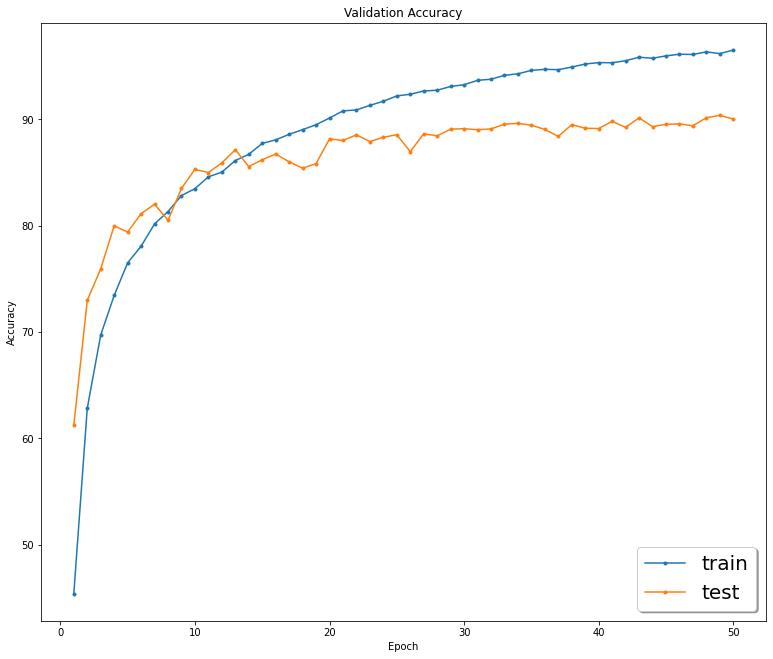

In [31]:
plot_metric({'train': results['resnet18']['train_acc'], 'test': results['resnet18']['test_acc']}, 'Accuracy')

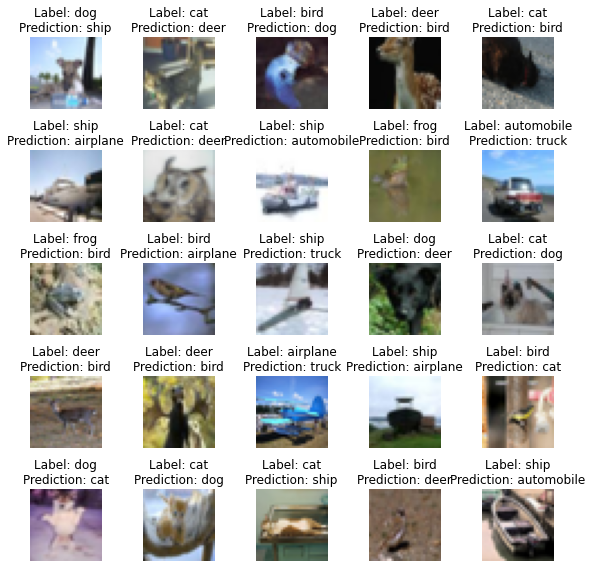

In [32]:
path_to_model = '/content/cifar10_model.pt'
incorrect_samples = identify_misclassification(ResNet18(), path_to_model, test_loader)

plot_results(incorrect_samples, cifar10.classes)


## Gradcam

**Generating gradcam for incorrect samples**

In [33]:
gcams = []

# Saving gradcam output into list
for x in incorrect_samples:
    gcams.append(plot_gradcam(image=(x['image'] + 1)*255 / 2,
                              model=model,
                              layer='layer4.1.conv2',
                              model_path='/content/cifar10_model.pt', 
                              classes= cifar10.classes
                              ))

 #GRADCAM: bird (prob : 1.0)
	 Generating Image : gradcam-ResNet-layer4.1.conv2-bird.png
 #GRADCAM: automobile (prob : 1.0)
	 Generating Image : gradcam-ResNet-layer4.1.conv2-automobile.png
 #GRADCAM: automobile (prob : 1.0)
	 Generating Image : gradcam-ResNet-layer4.1.conv2-automobile.png
 #GRADCAM: bird (prob : 1.0)
	 Generating Image : gradcam-ResNet-layer4.1.conv2-bird.png
 #GRADCAM: automobile (prob : 1.0)
	 Generating Image : gradcam-ResNet-layer4.1.conv2-automobile.png
 #GRADCAM: bird (prob : 1.0)
	 Generating Image : gradcam-ResNet-layer4.1.conv2-bird.png
 #GRADCAM: bird (prob : 1.0)
	 Generating Image : gradcam-ResNet-layer4.1.conv2-bird.png
 #GRADCAM: bird (prob : 1.0)
	 Generating Image : gradcam-ResNet-layer4.1.conv2-bird.png
 #GRADCAM: automobile (prob : 1.0)
	 Generating Image : gradcam-ResNet-layer4.1.conv2-automobile.png
 #GRADCAM: bird (prob : 1.0)
	 Generating Image : gradcam-ResNet-layer4.1.conv2-bird.png
 #GRADCAM: bird (prob : 1.0)
	 Generating Image : gradcam-ResN

In [34]:
import matplotlib.pyplot as plt
import numpy as np

def plot_incorrect_gradcam(incorrect_samples, gradcams, classes=None):

    fig, axs = plt.subplots(len(incorrect_samples), 2, figsize=(5, 64))
    fig.tight_layout()

    for idx, result in enumerate(incorrect_samples):

        label = classes[result['label'].item()] if classes else result['label'].item()
        prediction = classes[result['prediction'].item()] if classes else result['prediction'].item()

        # Plot image
        axs[idx][0].axis('off')
        axs[idx][0].set_title(f'Image: {idx+1}\nLabel: {label}')
        axs[idx][0].imshow(np.uint(((np.transpose(result['image'], (1, 2, 0)) + 1)*255) / 2))

        axs[idx][1].axis('off')
        axs[idx][1].set_title(f'Gradcam: {idx+1}\nPrediction: {prediction}')
        axs[idx][1].imshow(np.uint(gradcams[idx]))

    plt.show()
    fig.savefig(f'incorrect_predictions_gradcam.png', bbox_inches='tight')

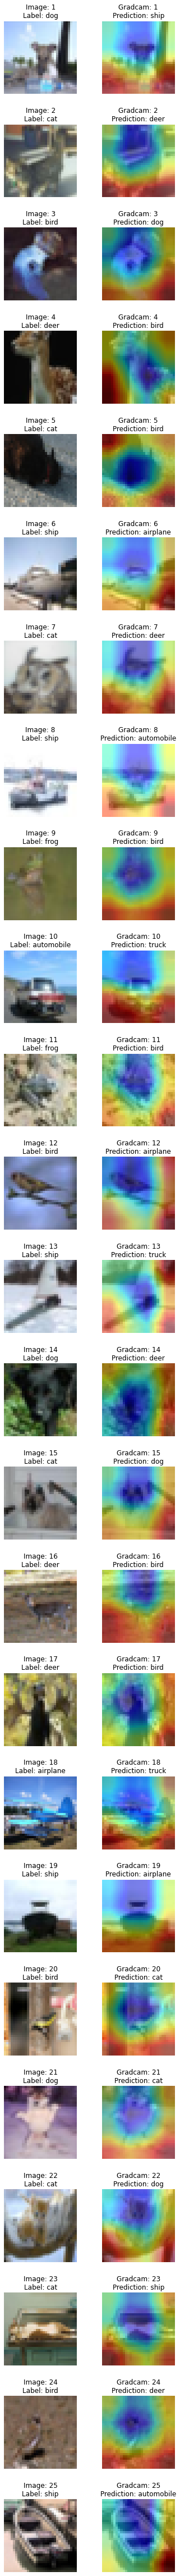

In [35]:
plot_incorrect_gradcam(incorrect_samples[:25], gcams, cifar10.classes)